In [1]:
from citrination_client import CitrinationClient
import saxskit
from saxskit.saxskit.saxs_models import get_data_from_Citrination

from pypif.pif import dumps
import json 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import yaml
from sklearn import preprocessing
from sklearn import linear_model
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeavePGroupsOut

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.neighbors.kde import KernelDensity
from time import time

In [2]:
with open("citrination_api_key_ssrl.txt", "r") as g: 
    api_key = g.readline()

a_key = api_key.strip()

client = CitrinationClient(site='https://slac.citrination.com',api_key=a_key ) 

In [3]:
t0 = time()
d = get_data_from_Citrination(client, [1,15,16])
print("It took ", time()-t0)

It took  124.49225401878357


In [4]:
d.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
948,R6,69.6784,2.71303,0.00232372,42.5446,4.11995,0.0812712,0.00185529,0.0933219,-0.546811,...,0,1,1,None,None,None,None,None,None,0
562,R4,1.44855,1.19832,0.0225415,5.65807,2.75074,0.143148,0.00185529,0.299214,0.293792,...,1,0,0,2.51472,2.31895,None,None,None,None,0.0337671
1175,R12,16.2602,1.02895,0.00104027,3.45984,2.83132,0.103267,0.00171821,0.0688484,-0.764441,...,0,1,0,None,None,None,790.178,31.3774,0.0454279,0.206495
269,R1,18.5594,1.03069,0.00109416,3.20008,2.78637,0.107467,0.00185529,0.0651967,-0.639523,...,0,1,0,None,None,None,1763.36,33.6887,0.0564587,0.0868149
1476,Reaction_A,3.77951,1.11135,0.0066177,19.7709,4.27128,0.125508,0.00238663,0.216581,0.256296,...,1,0,0,22.2753,4.86282,None,None,None,None,0


In [5]:
d.shape

(1946, 25)

**Steps to get a good linear regression model**
(by https://machinelearningmastery.com/linear-regression-for-machine-learning/)
1. Linear Assumption. Linear regression assumes that the relationship between your input and output is linear. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).
2. Remove Noise. Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.
3. Remove Collinearity. Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
4. Gaussian Distributions. Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
5. Rescale Inputs: Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

## Distribution of values for all features

In [8]:
data = d

We have a lot of q_max value about 0.04. It is not an error. Often our scatters are decreasing functions of intensivity from q. Thus, we often have max value of I for the smalles angel (q). 

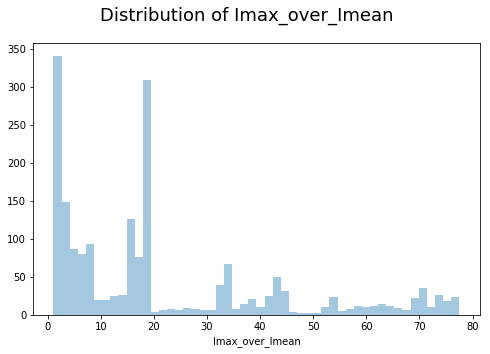

In [9]:
plt.figure(figsize=(8,5))
sns.distplot(data['Imax_over_Imean'], kde=False, bins=50)
plt.suptitle("Distribution of Imax_over_Imean ", fontsize=18)

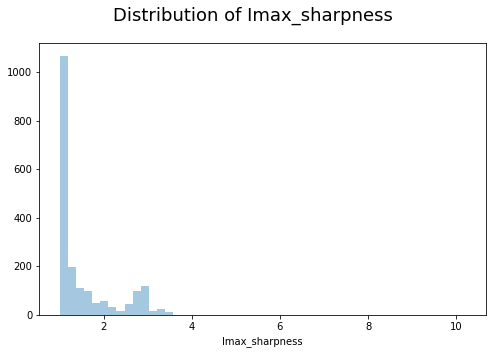

In [14]:
plt.figure(figsize=(8,5))
sns.distplot(data['Imax_sharpness'], kde=False, bins=50)
plt.suptitle("Distribution of Imax_sharpness ", fontsize=18)

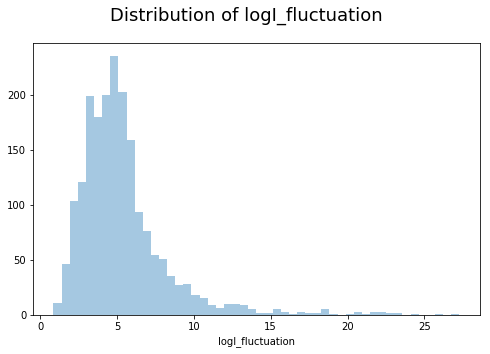

In [15]:
plt.figure(figsize=(8,5))
sns.distplot(data['logI_fluctuation'], kde=False, bins=50)
plt.suptitle("Distribution of logI_fluctuation ", fontsize=18)

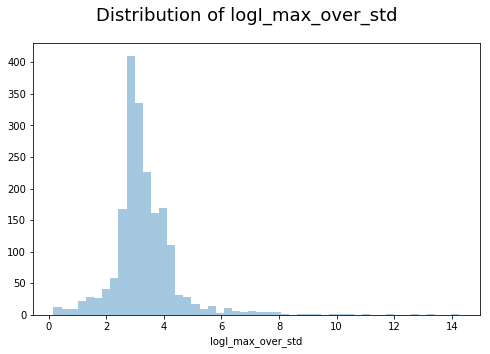

In [16]:
plt.figure(figsize=(8,5))
sns.distplot(data['logI_max_over_std'], kde=False, bins=50)
plt.suptitle("Distribution of logI_max_over_std ", fontsize=18)

### My Strategy for Dealing with Outliers

1. Exclude outliers for labels
2. At training / testing time exclude outliers from training and validation sets, but not exclude them from testing set.

## Spherical scatterer - size distribution paramentrs
### ro_sphere (mean radius)

In [14]:
data_sphere = d[d['r0_sphere'].isnull() == False]
data_sphere.shape

(726, 25)

In [15]:
data_sphere.experiment_id.value_counts()

R1            240
R12           117
R5             79
R13            77
Reaction_C     54
Reaction_D     42
Reaction_H     38
Reaction_E     36
Reaction_G      7
Reaction_A      6
R4              6
R2              5
R6              5
R7              5
Reaction_B      5
R3              4
Name: experiment_id, dtype: int64

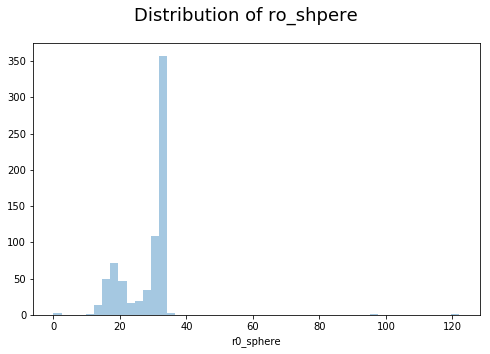

In [18]:
plt.figure(figsize=(8,5))
sns.distplot(data_sphere['r0_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of ro_shpere ", fontsize=18)

In [19]:
d.columns

Index(['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq', 'unidentified', 'guinier_porod',
       'spherical_normal', 'diffraction_peaks', 'G_gp', 'rg_gp', 'D_gp',
       'I0_sphere', 'r0_sphere', 'sigma_sphere', 'I0_floor'],
      dtype='object')

In [20]:
features = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

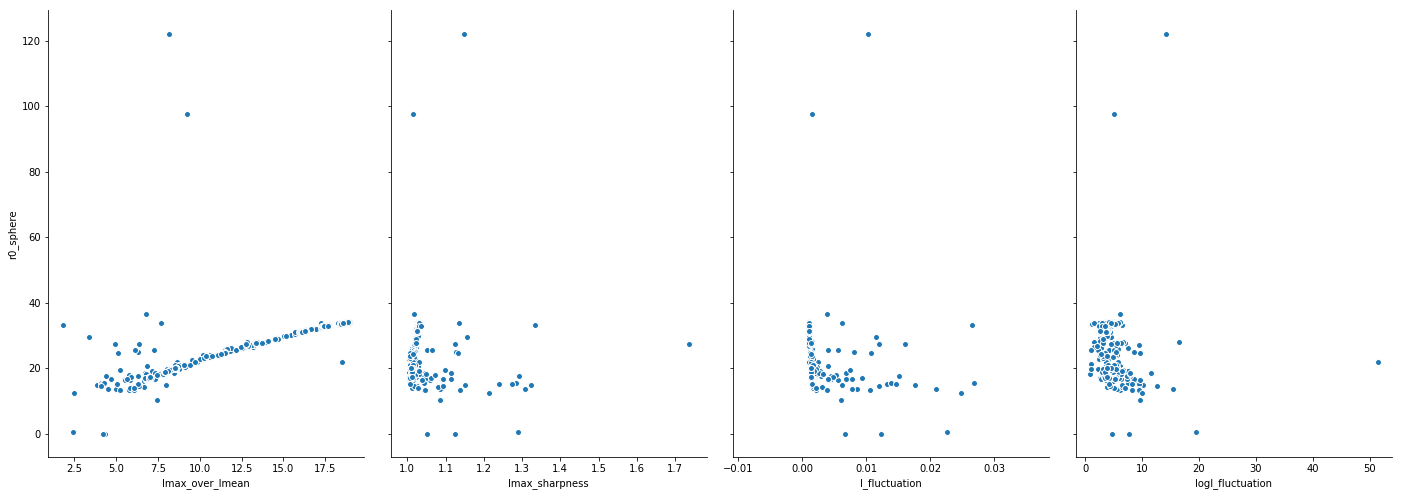

In [22]:
sns.pairplot(data_sphere, x_vars=['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation'], y_vars='r0_sphere', size=7, aspect=0.7)

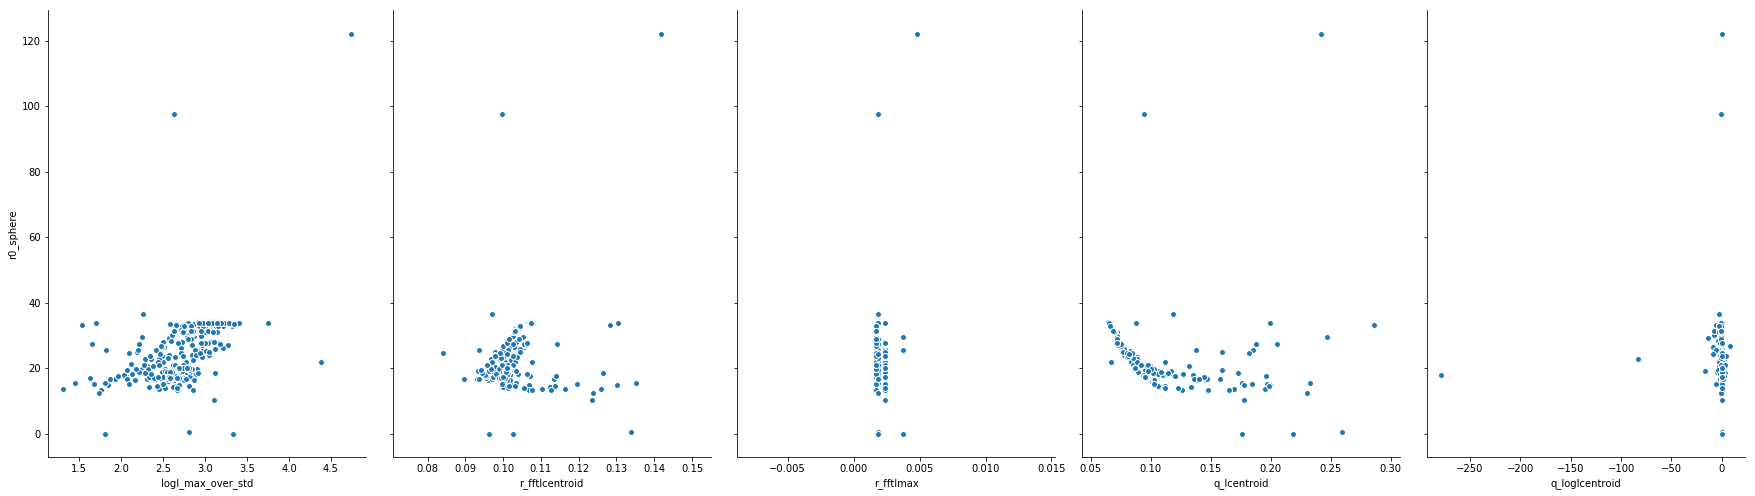

In [23]:
sns.pairplot(data_sphere, x_vars=['logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid'], y_vars='r0_sphere', size=7, aspect=0.7)

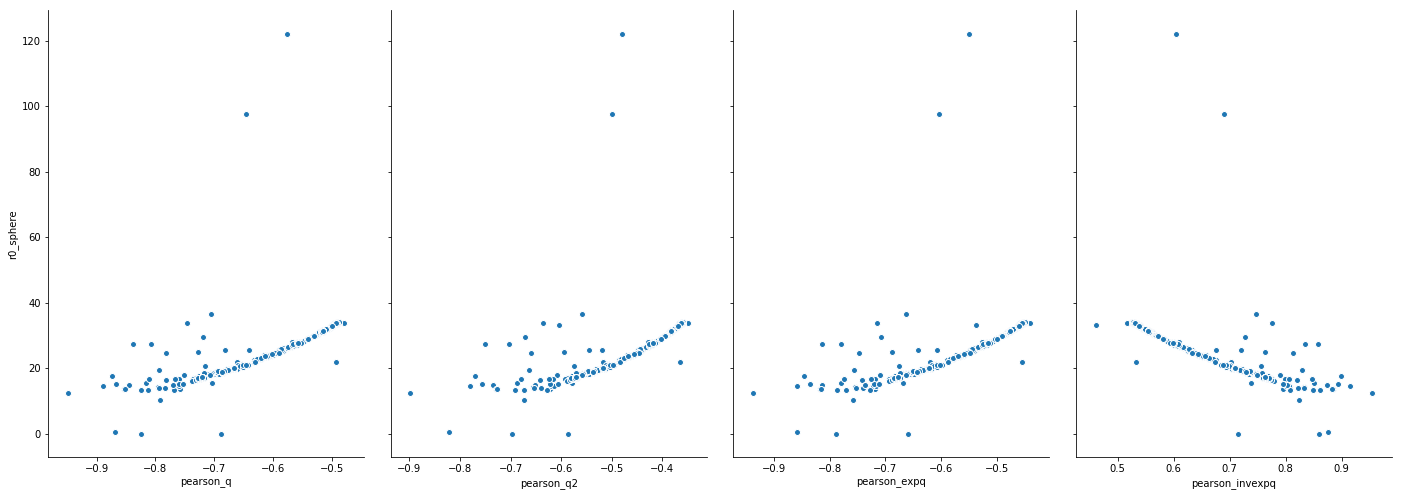

In [24]:
sns.pairplot(data_sphere, x_vars=['pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq'], y_vars='r0_sphere', size=7, aspect=0.7)

This visualization shows that:
1. We have only two features that are correlated with 'ro_shpere'
2. We have some outliers.

In [25]:
scaler = preprocessing.StandardScaler()
scaler.fit(data_sphere[features])
data_sphere[features] = scaler.transform(data_sphere[features])
data_sphere.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,guinier_porod,spherical_normal,diffraction_peaks,G_gp,rg_gp,D_gp,I0_sphere,r0_sphere,sigma_sphere,I0_floor
1175,R12,0.355818,-0.065367,-0.269532,-0.396362,-0.033540,-0.316003,-0.824645,-0.384650,0.012592,...,0,1,0,None,None,None,790.178,31.3774,0.0454279,0.206495
269,R1,0.826148,-0.024566,-0.249119,-0.505172,-0.179696,0.576426,-0.370667,-0.510710,0.024113,...,0,1,0,None,None,None,1763.36,33.6887,0.0564587,0.0868149
806,R5,0.864376,0.002619,-0.249314,0.034310,1.038479,0.614819,-0.370667,-0.502989,0.076497,...,0,1,0,None,None,None,2003.9,33.9429,0.0412616,0.299991
1796,Reaction_E,-1.451983,1.248246,1.647264,2.209422,0.843064,3.977933,1.389109,3.369816,0.092515,...,1,1,0,4.3769,4.66359,None,13.9542,10.3025,0.644579,0.00477838
164,R1,0.879416,0.042510,-0.247915,0.241515,0.628175,0.660092,-0.370667,-0.515636,0.058913,...,0,1,0,None,None,None,1391.76,33.889,0.0339873,0.256534


In [26]:
#remove outliers for target variables only
labels = ['r0_sphere']
st =  data_sphere[labels].std()
m = data_sphere[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_sphere[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

data_sphere = pd.concat([data_sphere.loc[:,c], filt_df], axis=1)
data_sphere.dropna(inplace=True)
data_sphere.shape

(721, 15)

In [27]:
data_sphere_test = data_sphere

In [28]:
# training data: remove outliers from features
st =  data_sphere[features].std()
m = data_sphere[features].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_sphere[features].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'r0_sphere']
data_sphere = pd.concat([data_sphere.loc[:,c], filt_df], axis=1)
data_sphere.dropna(inplace=True)
data_sphere.shape

(683, 15)

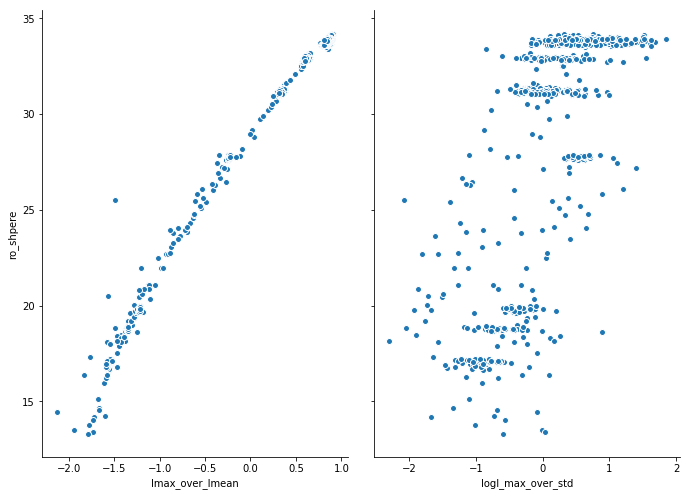

In [150]:
sns.pairplot(data_sphere, x_vars=[ 'Imax_over_Imean',  
                                 'logI_max_over_std'], y_vars='ro_shpere', size=7, aspect=0.7)

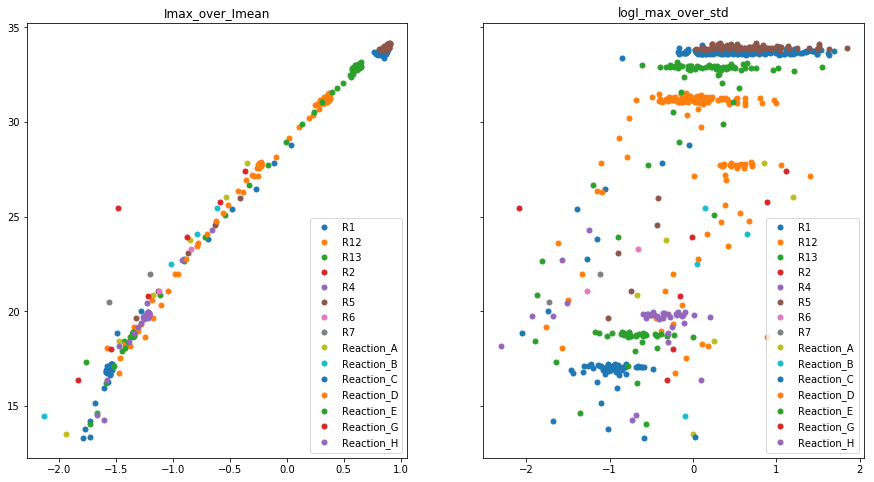

In [81]:
groups = data_sphere.groupby('experiment_id')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.Imax_over_Imean, group.ro_shpere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Imax_over_Imean')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.ro_shpere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

plt.show()

#### Loss 

* ‘squared_loss’ ordinary least squares fit
* ‘huber’modifies ‘squared_loss’ to focus less on getting outliers correct by switching from squared to linear loss past a distance of epsilon.  
* ‘epsilon_insensitive’ignores errors less than epsilon and is linear past that; 
* ‘squared_epsilon_insensitive’is the same but becomes squared loss past a tolerance of epsilon.

**We have grouped data. From some experiments we have a lot of almost the same samples, but from some other experiments we have few uniqe data. Thus, I decided to use weighted loss function. Samples that are from the same experimets and that are close in the features space will have less weight that "single" samples.**

In [82]:
data_sphere.experiment_id.value_counts()

R1            234
R12           114
R5             74
R13            73
Reaction_C     53
Reaction_D     41
Reaction_H     37
Reaction_E     35
Reaction_A      6
Reaction_G      6
Reaction_B      4
R4              3
R6              2
R7              2
R2              1
Name: experiment_id, dtype: int64

Remouving outliers we lost data from R3

In [176]:
experiments = data_sphere.experiment_id.unique()
experiments

array(['R1', 'R2', 'R4', 'R5', 'R6', 'R7', 'R12', 'R13', 'Reaction_A',
       'Reaction_B', 'Reaction_C', 'Reaction_D', 'Reaction_E',
       'Reaction_G', 'Reaction_H'], dtype=object)

In [84]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['logI_max_over_std', 'Imax_over_Imean']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0, 'loss': 'squared_loss', 'penalty': 'none'}
Training score R2:  0.532


In [85]:
std_ro_shpere = data_sphere_test['ro_shpere'].std()

In [86]:
features = ['logI_max_over_std', 'Imax_over_Imean']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty = 'l1')
        reg.fit(tr[features], tr['ro_shpere'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.629127261728
test score mean squared error normalized:  0.13245176392

Testing on:  R2
R2 score:  -104.928415068
test score mean squared error normalized:  1.82069942458

Testing on:  R4
R2 score:  -0.586774065802
test score mean squared error normalized:  0.883175221679

Testing on:  R5
R2 score:  0.946538743043
test score mean squared error normalized:  0.108528350282

Testing on:  R6
R2 score:  -0.435241453916
test score mean squared error normalized:  0.30990245469

Testing on:  R7
R2 score:  -0.989704506357
test score mean squared error normalized:  0.676213048741

Testing on:  R12
R2 score:  0.567161301957
test score mean squared error normalized:  0.270388021789

Testing on:  R13
R2 score:  0.803717763898
test score mean squared error normalized:  0.23667447811

Testing on:  Reaction_A
R2 score:  0.879581323603
test score mean squared error normalized:  0.204209238463

Testing on:  Reaction_B
R2 score:  0.803082648962
test score mean squared error no

In [87]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['Imax_over_Imean']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0.5, 'loss': 'squared_loss', 'penalty': 'none'}
Training score R2:  0.808


In [92]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty = 'none')
        reg.fit(tr[features], tr['ro_shpere'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.626548177464
test score mean squared error normalized:  0.13307004299

Testing on:  R2
R2 score:  -105.474594578
test score mean squared error normalized:  1.82539111851

Testing on:  R4
R2 score:  -0.580869886368
test score mean squared error normalized:  0.877911034142

Testing on:  R5
R2 score:  0.94355537095
test score mean squared error normalized:  0.111549749404

Testing on:  R6
R2 score:  -0.407878594575
test score mean squared error normalized:  0.309296554612

Testing on:  R7
R2 score:  -1.05504401402
test score mean squared error normalized:  0.68752480239

Testing on:  R12
R2 score:  0.552826683563
test score mean squared error normalized:  0.27330392813

Testing on:  R13
R2 score:  0.794055121279
test score mean squared error normalized:  0.242409221737

Testing on:  Reaction_A
R2 score:  0.896860547842
test score mean squared error normalized:  0.191410257977

Testing on:  Reaction_B
R2 score:  0.802303385167
test score mean squared error norm

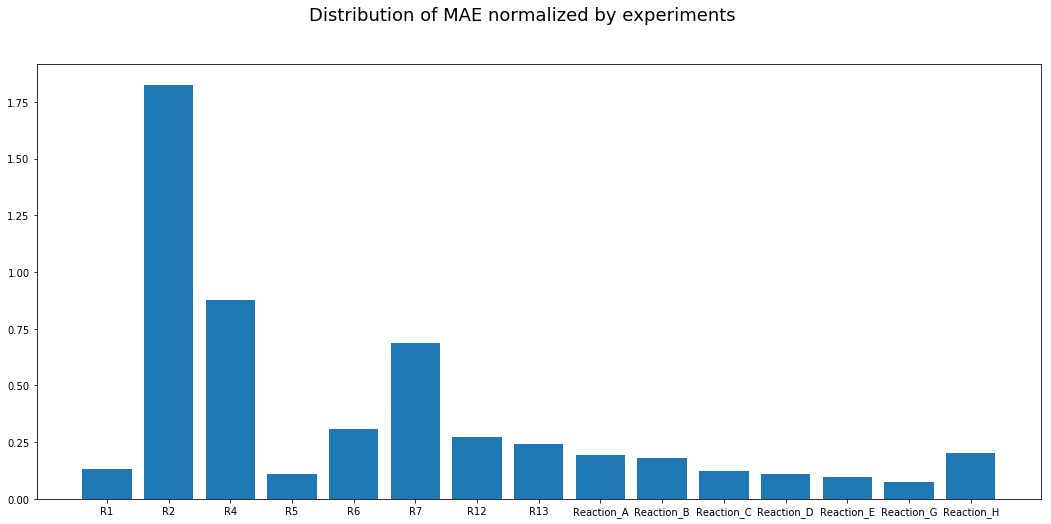

In [93]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

### Using Kernel Density as weights

It calculates the density of features in a neighborhood around those features.

How might we determine the optimal bandwidth for any given problem?
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

I wil use cross validation to find 'bandwidth' that wil give me the maximum likelihood.

In [31]:
# Demo using only one feature:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[['Imax_over_Imean']])
grid.best_params_

{'bandwidth': 0.044137931034482762}

In [762]:
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data_sphere[[ 'Imax_over_Imean']])
kde3 = KernelDensity(kernel='gaussian', bandwidth=0.004).fit(data_sphere[[ 'Imax_over_Imean']])

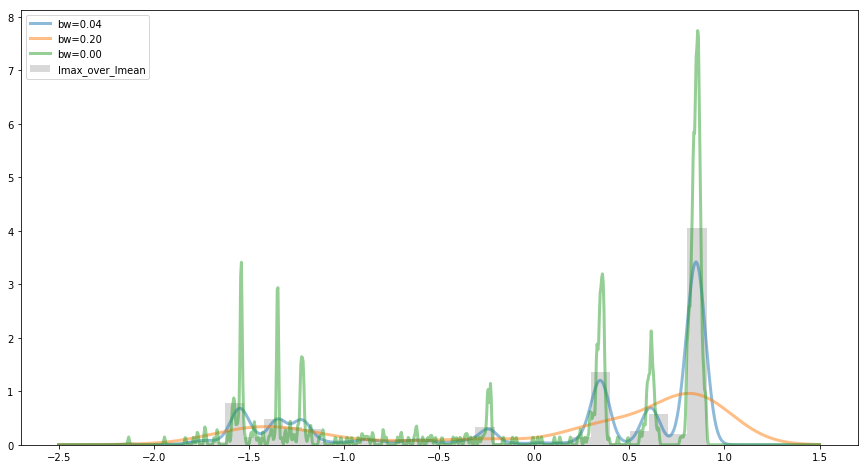

In [763]:
x_grid = np.linspace(-2.5, 1.5, 1000)

kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))
pdf1 = np.exp(kde1.score_samples(x_grid[:, None]))
pdf3 = np.exp(kde3.score_samples(x_grid[:, None]))

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.plot(x_grid, pdf1, linewidth=3, alpha=0.5, label='bw=%.2f' % kde1.bandwidth)
ax.plot(x_grid, pdf3, linewidth=3, alpha=0.5, label='bw=%.2f' % kde3.bandwidth)
ax.hist(data_sphere['Imax_over_Imean'], 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.legend(loc='upper left')
#ax.set_xlim(-4.5, 3.5);

GridSearch gives us a good value for bandwidth. Blue line (bw = 0.04) is the most reasonable. 

To calculate kernel density for our training data, I will use 'ro_shpere',  'logI_max_over_std', and 'Imax_over_Imean'.

In [32]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[['ro_shpere',  'logI_max_over_std', 'Imax_over_Imean']])
grid.best_params_

{'bandwidth': 0.18068965517241381}

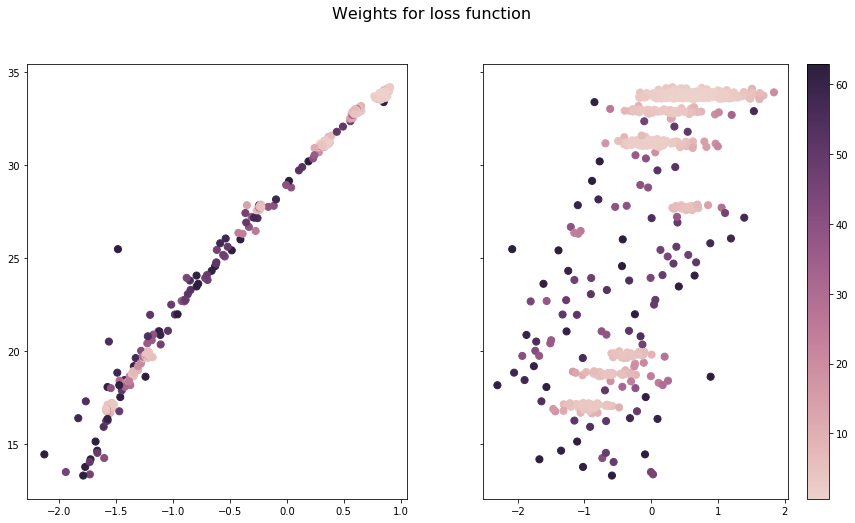

In [177]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.18).fit(data_sphere[['ro_shpere',  'logI_max_over_std', 'Imax_over_Imean']])

# score_samples() returns the log-likelihood of the samples
log_pdf = kde.score_samples(data_sphere[['ro_shpere',  'logI_max_over_std', 'Imax_over_Imean']])
sc = 1/np.exp(log_pdf)

data_sphere['weights'] = sc

cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_sphere.Imax_over_Imean, data_sphere.ro_shpere, c=sc, s=50, cmap=cmap)
points2 = ax2.scatter(data_sphere.logI_max_over_std, data_sphere.ro_shpere, c=sc, s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

### Grid search for the best model

In [34]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['logI_max_over_std', 'Imax_over_Imean']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 1, 'l1_ratio': 0.15, 'loss': 'squared_loss', 'penalty': 'l1'}
Training score R2:  0.779


In [178]:
std_ro_shpere = data_sphere_test['ro_shpere'].std()

In [179]:
features = ['logI_max_over_std', 'Imax_over_Imean']

test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty = 'l1')
        reg.fit(tr[features], tr['ro_shpere'], sample_weight=tr['weights'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.627991975435
test score mean squared error normalized:  0.22541631397

Testing on:  R2
R2 score:  -66.271342849
test score mean squared error normalized:  1.45826371516

Testing on:  R4
R2 score:  -0.335310136841
test score mean squared error normalized:  0.654583577536

Testing on:  R5
R2 score:  0.920645013696
test score mean squared error normalized:  0.188862003097

Testing on:  R6
R2 score:  0.526662171961
test score mean squared error normalized:  0.192929761729

Testing on:  R7
R2 score:  0.111170847065
test score mean squared error normalized:  0.437596158509

Testing on:  R12
R2 score:  0.98972896114
test score mean squared error normalized:  0.0297659572459

Testing on:  R13
R2 score:  0.988747876389
test score mean squared error normalized:  0.0667745888479

Testing on:  Reaction_A
R2 score:  0.939085315323
test score mean squared error normalized:  0.165471997847

Testing on:  Reaction_B
R2 score:  0.819401855007
test score mean squared error no

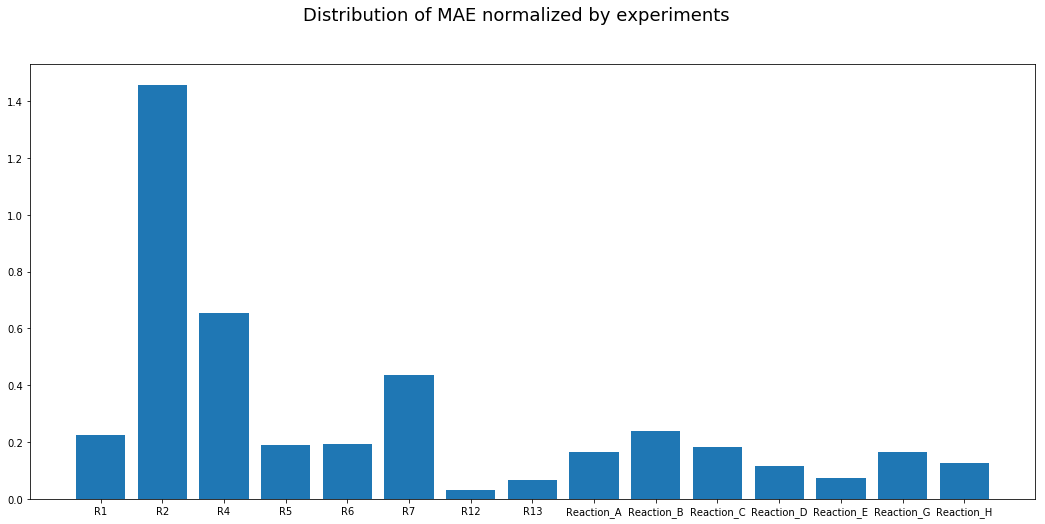

In [180]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

We have only one sample in the experiment R2.

In [90]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['Imax_over_Imean']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.01, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}
Training score R2:  0.771


In [91]:
features = ['logI_max_over_std', 'Imax_over_Imean']

test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty = 'l1')
        reg.fit(tr[features], tr['ro_shpere'], sample_weight=tr['weights'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.850979957869
test score mean squared error normalized:  0.120629641514

Testing on:  R2
R2 score:  -75.6500600755
test score mean squared error normalized:  1.55910760989

Testing on:  R4
R2 score:  -0.1472940707
test score mean squared error normalized:  0.495122955639

Testing on:  R5
R2 score:  0.912810561242
test score mean squared error normalized:  0.197245004879

Testing on:  R6
R2 score:  0.57384481297
test score mean squared error normalized:  0.172941675777

Testing on:  R7
R2 score:  -0.652630853985
test score mean squared error normalized:  0.61706432076

Testing on:  R12
R2 score:  0.989223702412
test score mean squared error normalized:  0.0357454343032

Testing on:  R13
R2 score:  0.993395362599
test score mean squared error normalized:  0.050011975973

Testing on:  Reaction_A
R2 score:  0.931054201242
test score mean squared error normalized:  0.181063086169

Testing on:  Reaction_B
R2 score:  0.908364895475
test score mean squared error nor

### Using all features

In [38]:
features_label = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std','ro_shpere' ]
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[features])
grid.best_params_

{'bandwidth': 0.14655172413793105}

In [39]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(data_sphere[features_label])

log_pdf = kde.score_samples(data_sphere[features_label])
sc = 1/np.exp(log_pdf)

data_sphere['weights_5_features'] = sc

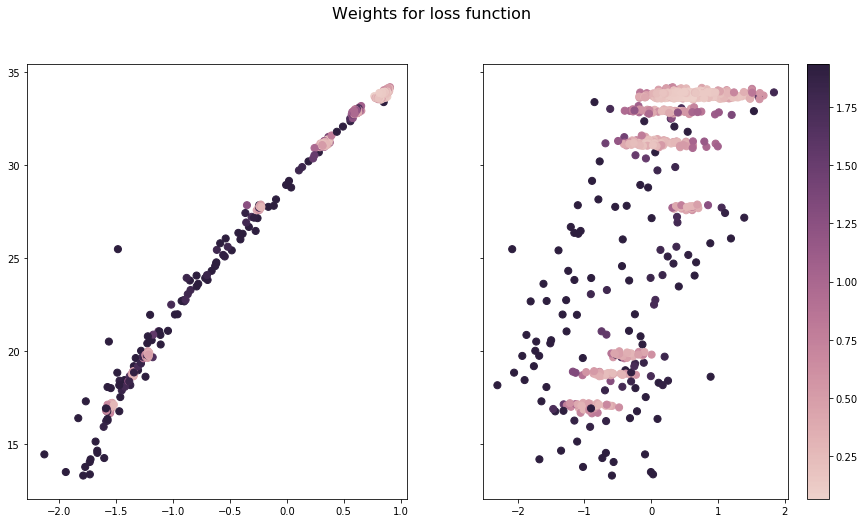

In [40]:
cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_sphere.Imax_over_Imean, data_sphere.ro_shpere, c=data_sphere['weights_5_features'], s=50, cmap=cmap)
points2 = ax2.scatter(data_sphere.logI_max_over_std, data_sphere.ro_shpere, c=data_sphere['weights_5_features'], s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

It looks like that weights we got using kde with only two features is better that this one (using 5 features).

#### Using weights from 5 features

In [41]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights_5_features'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 0.001, 'l1_ratio': 0.15, 'loss': 'squared_loss', 'penalty': 'none'}
Training score R2:  -2.795


We got a very bad R2

#### Now I will try to use weights that I got from 2 features

In [42]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 0, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}
Training score R2:  0.859


In [182]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001, loss= 'squared_loss', penalty= 'l2')
        #reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'elasticnet', l1_ratio = 0.95)
        reg.fit(tr[features], tr['ro_shpere'], sample_weight=tr['weights'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.727879088698
test score mean squared error normalized:  0.161004679026

Testing on:  R2
R2 score:  -75.7983637815
test score mean squared error normalized:  1.39908735191

Testing on:  R4
R2 score:  0.265791932154
test score mean squared error normalized:  0.499222796578

Testing on:  R5
R2 score:  0.970004766745
test score mean squared error normalized:  0.107771197452

Testing on:  R6
R2 score:  -2.20207407662
test score mean squared error normalized:  0.422387055554

Testing on:  R7
R2 score:  -3.78570202156
test score mean squared error normalized:  0.654761609319

Testing on:  R12
R2 score:  0.959485622571
test score mean squared error normalized:  0.0584083794259

Testing on:  R13
R2 score:  0.973213676172
test score mean squared error normalized:  0.0737493522042

Testing on:  Reaction_A
R2 score:  0.920789916775
test score mean squared error normalized:  0.178738915114

Testing on:  Reaction_B
R2 score:  0.889757165954
test score mean squared error 

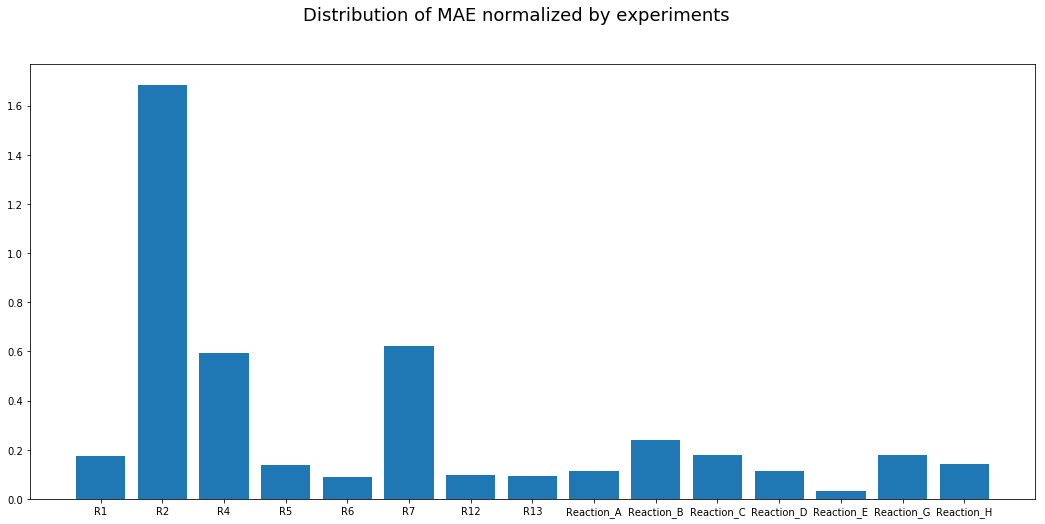

In [44]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

**We got the best result using weighted regression with five features, but I used only two features to calculate the weights**

In [45]:
reg.coef_

array([ 1.36709158,  6.52547088, -0.72238581,  1.07121196, -0.40595151])

All features make some contribution into result. **Imax_over_Imean** it the most important feature.

### Sigma-sphere

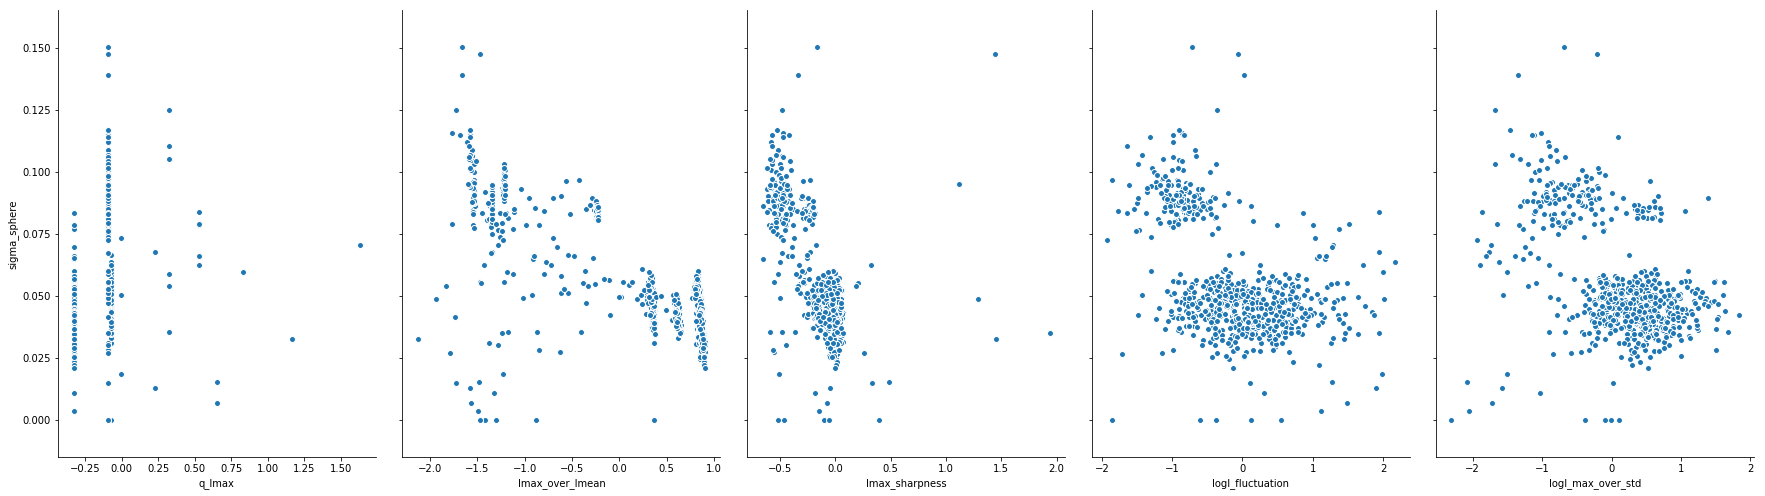

In [46]:
sns.pairplot(data_sphere, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='sigma_sphere', size=7, aspect=0.7)

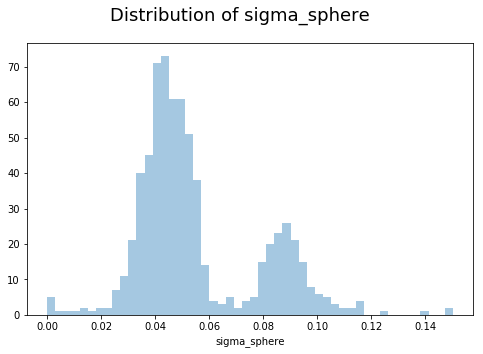

In [47]:
plt.figure(figsize=(8,5))
sns.distplot(data_sphere['sigma_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of sigma_sphere ", fontsize=18)

In [48]:
# we need to remove all samples with 'sigma_sphere' == 0
data_sphere = data_sphere[data_sphere['sigma_sphere'] > 0.01]
data_sphere.shape

(678, 10)

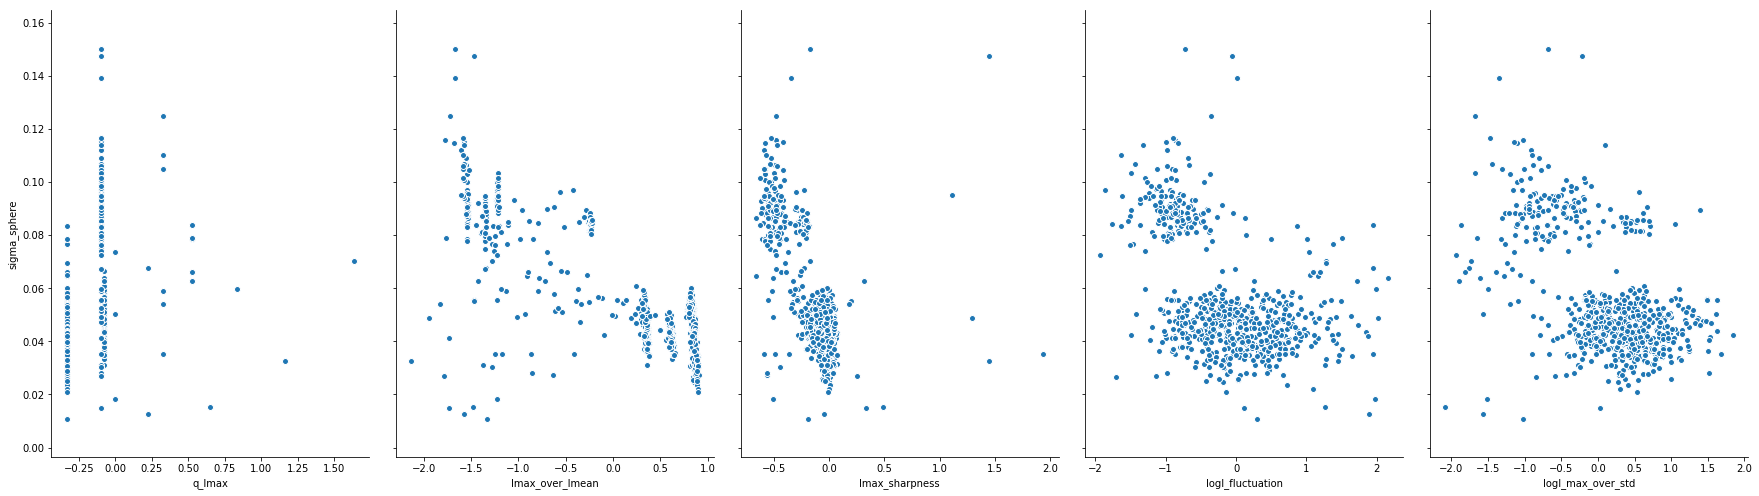

In [49]:
sns.pairplot(data_sphere, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='sigma_sphere', size=7, aspect=0.7)

In [62]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

for f in features:
    reg = linear_model.SGDRegressor(max_iter=10000)
    reg.fit(data_sphere[[f]], data_sphere['sigma_sphere'])
    pred = reg.predict(data_sphere[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_sphere['sigma_sphere'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_sphere['sigma_sphere'], pred))

Mean squared error: 0.00044
Variance score: 0.11470
Mean squared error: 0.00019
Variance score: 0.60606
Mean squared error: 0.00031
Variance score: 0.36524
Mean squared error: 0.00038
Variance score: 0.23069
Mean squared error: 0.00036
Variance score: 0.27434


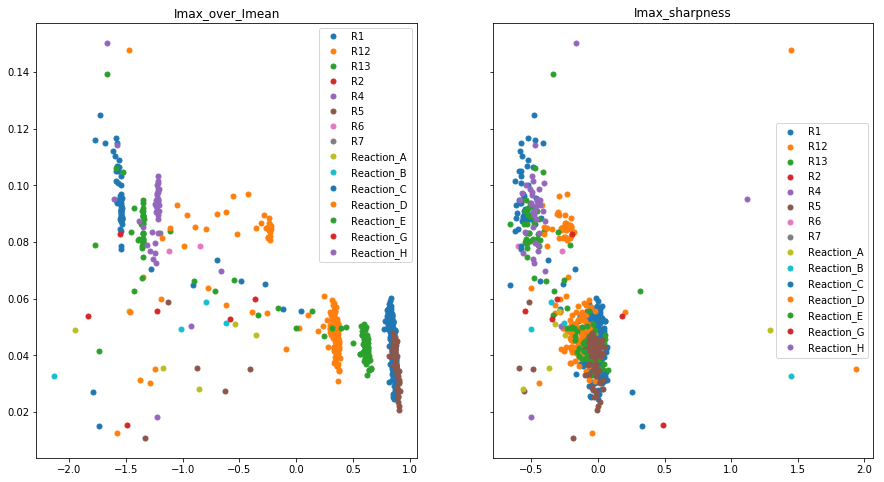

In [51]:
groups = data_sphere.groupby('experiment_id')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.Imax_over_Imean, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Imax_over_Imean')
ax1.legend()

for name, group in groups:
    ax2.plot(group.Imax_sharpness, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('Imax_sharpness')
ax2.legend()

plt.show()

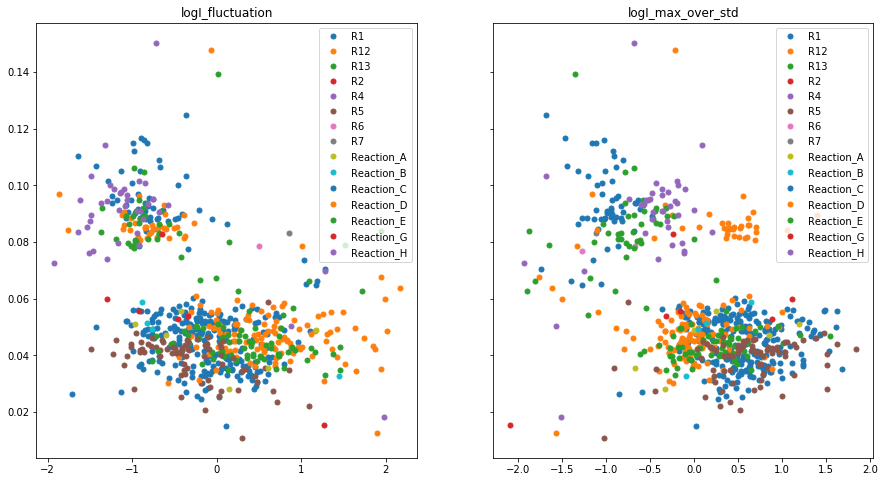

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.logI_fluctuation, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('logI_fluctuation')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

plt.show()

I will use only 'Imax_over_Imean'and 'Imax_sharpness' to calculate the weights since we have "groupping" in thes two features.

In [53]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[['sigma_sphere',  'Imax_over_Imean', 'Imax_sharpness']])
grid.best_params_

{'bandwidth': 0.044137931034482762}

In [54]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.044).fit(data_sphere[['sigma_sphere',  'Imax_over_Imean', 'Imax_sharpness']])

log_pdf = kde.score_samples(data_sphere[['sigma_sphere',  'Imax_over_Imean', 'Imax_sharpness']])
sc = 1/np.exp(log_pdf)

data_sphere['weights_sigma_sphere_2_features'] = sc

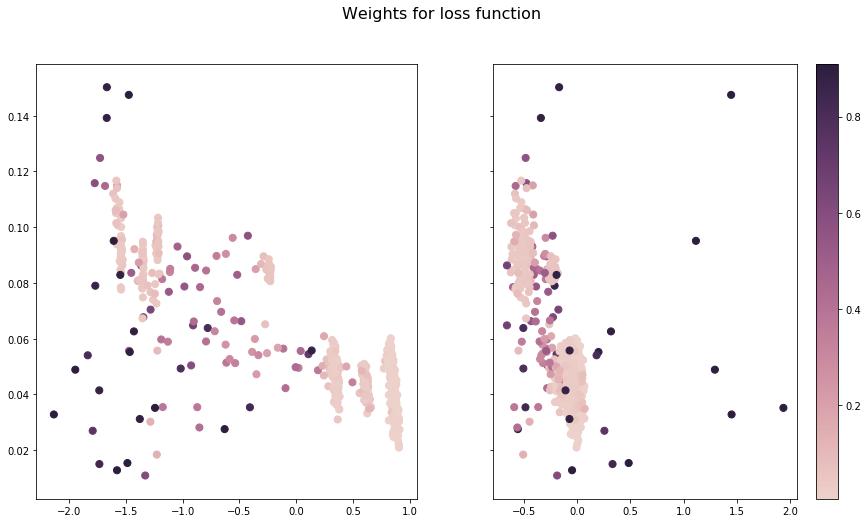

In [55]:
cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_sphere.Imax_over_Imean, data_sphere.sigma_sphere, c=data_sphere['weights_sigma_sphere_2_features'], s=50, cmap=cmap)
points2 = ax2.scatter(data_sphere.Imax_sharpness, data_sphere.sigma_sphere, c=data_sphere['weights_sigma_sphere_2_features'], s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

In this case using weights is not reasonable. Outliers get too much weights.

#### Using all features

In [69]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['sigma_sphere']], groups=data_sphere['experiment_id'])

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['sigma_sphere'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 1, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}
Training score R2:  -0.690


In [70]:
std_sigma_sphere = data_sphere_test['sigma_sphere'].std()

In [71]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
        reg.fit(tr[features], tr['sigma_sphere'])
        test_r2 = reg.score(test[features], test['sigma_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['sigma_sphere'])
        print('test score mean squared error normalized: ', test_score / std_sigma_sphere)
        test_scores_by_ex.append(test_score/std_sigma_sphere)
        stat_dic[experiments[i]] = test_score/std_sigma_sphere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.0742790404049
test score mean squared error normalized:  0.313084083903

Testing on:  R2
R2 score:  -17.0990535259
test score mean squared error normalized:  4.67239320071

Testing on:  R4
R2 score:  -1.43728646193
test score mean squared error normalized:  1.31470705606

Testing on:  R5
R2 score:  -2.02473190152
test score mean squared error normalized:  0.491641284157

Testing on:  R6
R2 score:  0.46830607877
test score mean squared error normalized:  0.903932310147

Testing on:  R7
R2 score:  -3.35012340088
test score mean squared error normalized:  2.19983205037

Testing on:  R12
R2 score:  -1.98129923668
test score mean squared error normalized:  0.400105436022

Testing on:  R13
R2 score:  -1.93734757184
test score mean squared error normalized:  0.360759327123

Testing on:  Reaction_A
R2 score:  -6.74308952439
test score mean squared error normalized:  0.977188938915

Testing on:  Reaction_B
R2 score:  -3.4331530457
test score mean squared error norm

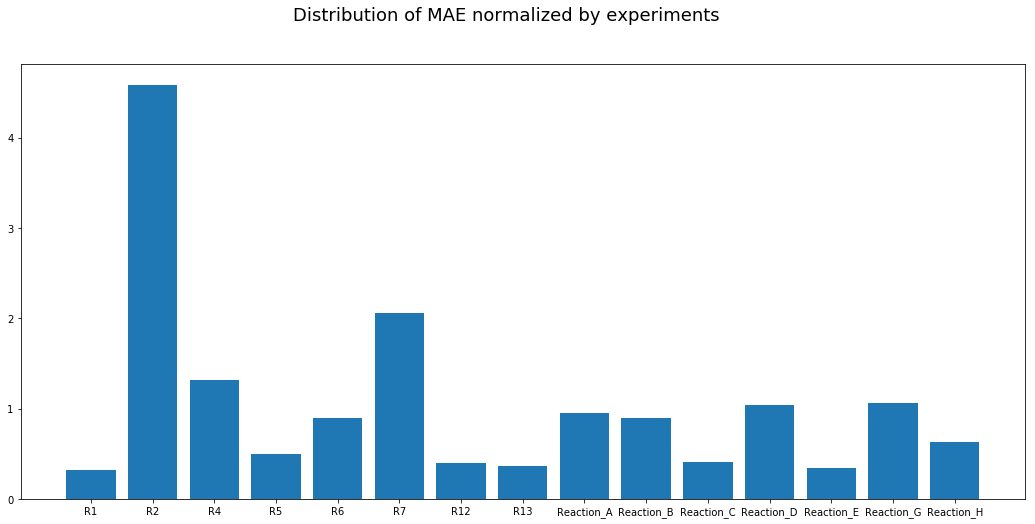

In [59]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

#### Using Imax_over_Imean only

In [67]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['sigma_sphere']], groups=data_sphere['experiment_id'])

features = ['Imax_over_Imean']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['sigma_sphere'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.1, 'l1_ratio': 0, 'loss': 'huber', 'penalty': 'elasticnet'}
Training score R2:  -0.880


In [68]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'huber', penalty= 'elasticnet', l1_ratio = 0, epsilon =0.1)
        reg.fit(tr[features], tr['sigma_sphere'])
        test_r2 = reg.score(test[features], test['sigma_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['sigma_sphere'])
        print('test score mean squared error normalized: ', test_score / std_sigma_sphere)
        test_scores_by_ex.append(test_score/std_sigma_sphere)
        stat_dic[experiments[i]] = test_score/std_sigma_sphere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.679183481845
test score mean squared error normalized:  0.393326577568

Testing on:  R2
R2 score:  -0.247568976134
test score mean squared error normalized:  1.09013043722

Testing on:  R4
R2 score:  -5.77386371742
test score mean squared error normalized:  2.21290311332

Testing on:  R5
R2 score:  -1.46154340601
test score mean squared error normalized:  0.376071845883

Testing on:  R6
R2 score:  -0.620176961281
test score mean squared error normalized:  1.04443231921

Testing on:  R7
R2 score:  -1.89084526202
test score mean squared error normalized:  1.8521270707

Testing on:  R12
R2 score:  0.0992864860713
test score mean squared error normalized:  0.354834589339

Testing on:  R13
R2 score:  0.681052246318
test score mean squared error normalized:  0.254773862947

Testing on:  Reaction_A
R2 score:  -12.8413801621
test score mean squared error normalized:  1.37477682517

Testing on:  Reaction_B
R2 score:  -7.88458340805
test score mean squared error nor

#### Using 'Imax_over_Imean' and 'Imax_sharpness'

In [64]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['sigma_sphere']], groups=data_sphere['experiment_id'])

features = ['Imax_over_Imean', 'Imax_sharpness']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['sigma_sphere'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0, 'l1_ratio': 0.5, 'loss': 'squared_loss', 'penalty': 'none'}
Training score R2:  -0.748


In [66]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty= 'none')
        reg.fit(tr[features], tr['sigma_sphere'])
        test_r2 = reg.score(test[features], test['sigma_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['sigma_sphere'])
        print('test score mean squared error normalized: ', test_score / std_sigma_sphere)
        test_scores_by_ex.append(test_score/std_sigma_sphere)
        stat_dic[experiments[i]] = test_score/std_sigma_sphere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.560870602576
test score mean squared error normalized:  0.39675093419

Testing on:  R2
R2 score:  -11.0276915572
test score mean squared error normalized:  3.21398073627

Testing on:  R4
R2 score:  -3.04829788721
test score mean squared error normalized:  1.58843412612

Testing on:  R5
R2 score:  -1.69732300813
test score mean squared error normalized:  0.404316010758

Testing on:  R6
R2 score:  -0.0110015621403
test score mean squared error normalized:  0.822243462396

Testing on:  R7
R2 score:  -1.5543301406
test score mean squared error normalized:  1.67623840975

Testing on:  R12
R2 score:  -0.845215118052
test score mean squared error normalized:  0.399191640254

Testing on:  R13
R2 score:  -0.489197654863
test score mean squared error normalized:  0.325917286478

Testing on:  Reaction_A
R2 score:  -10.5711545463
test score mean squared error normalized:  1.23684731084

Testing on:  Reaction_B
R2 score:  -4.07469968738
test score mean squared error no

**We got the best result using Using Imax_over_Imean only: 0.94**

## Precursor paramentrs
### G_precursor

In [183]:
# I will use only data with precursor= True and struture = False
data_precursor = data[(data['precursor']== True) & (data['structure']==False)]
data_precursor.shape

(518, 14)

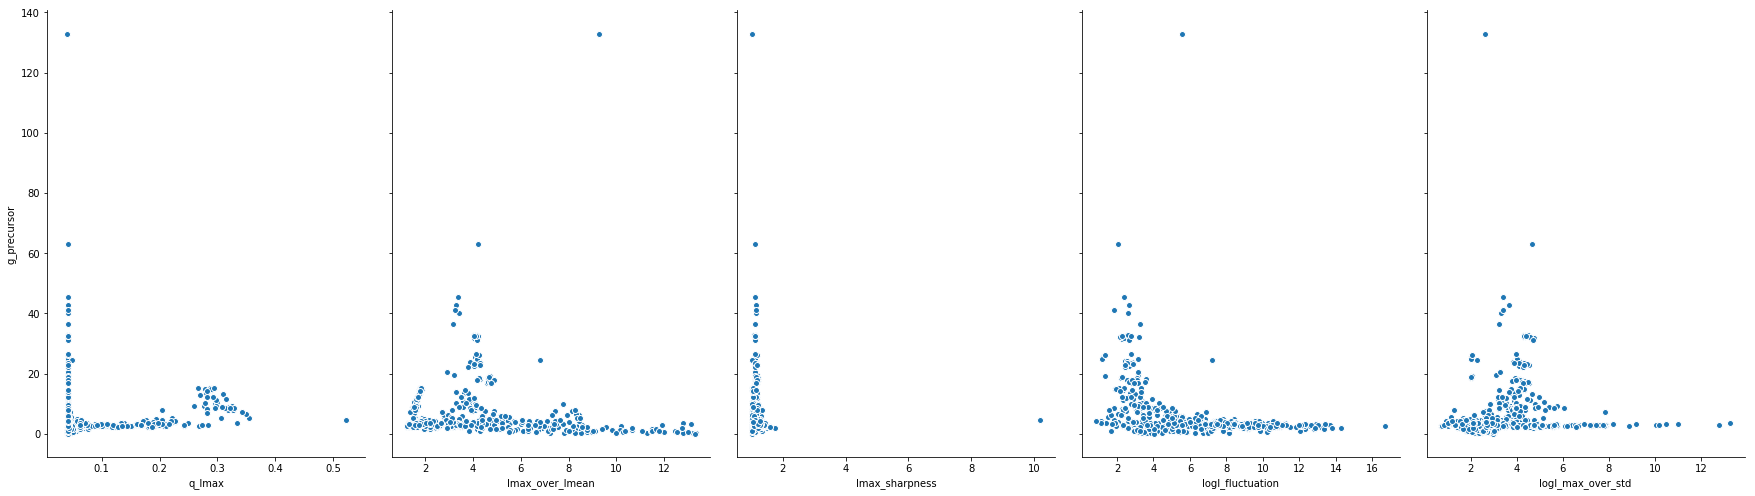

In [184]:
sns.pairplot(data_precursor, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='g_precursor', size=7, aspect=0.7)

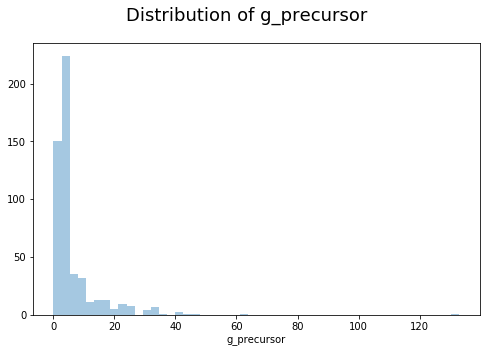

In [185]:
plt.figure(figsize=(8,5))
sns.distplot(data_precursor['g_precursor'], kde=False, bins=50)
plt.suptitle("Distribution of g_precursor ", fontsize=18)

In [186]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

scaler = preprocessing.StandardScaler()
scaler.fit(data_precursor[features])
data_precursor[features] = scaler.transform(data_precursor[features])
data_precursor.head()

,experiment_id,q_Imax,Imax_over_Imean,Imax_sharpness,logI_fluctuation,logI_max_over_std,bad_data,form,precursor,structure,ro_shpere,sigma_sphere,g_precursor,rg_precursor
453,R3,-0.404641,0.743675,-0.257177,-1.507139,-1.038998,0.0,1.0,1.0,0.0,25.57229,0.124409,3.718422,4.123645
310,R2,-0.207987,-0.593285,0.038379,0.541414,-1.280799,0.0,0.0,1.0,0.0,NaN,NaN,3.355838,5.044899
1772,Reaction_E,-0.552622,0.122223,0.133137,-0.464272,0.187155,0.0,0.0,1.0,0.0,NaN,NaN,5.888913,4.362194
1847,Reaction_G,-0.552622,-0.477023,-0.213223,0.401026,-0.641647,0.0,0.0,1.0,0.0,NaN,NaN,4.418818,4.472322
884,R6,0.735952,-0.929318,0.100109,0.950804,-0.063052,0.0,0.0,1.0,0.0,NaN,NaN,2.771080,2.918550


In [187]:
#remove outliers for target variables only
labels = ['g_precursor','rg_precursor']
st =  data_precursor[labels].std()
m = data_precursor[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std']

data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(492, 8)

In [188]:
data_precursor_test = data_precursor

# training data: remove outliers from features

cols = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std']

st =  data_precursor[cols].std()
m = data_precursor[cols].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[cols].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'g_precursor','rg_precursor']
data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(432, 8)

In [189]:
data_precursor.experiment_id.value_counts()

Reaction_B    43
Reaction_D    42
Reaction_C    41
R7            38
R2            37
Reaction_H    36
R4            33
R6            32
Reaction_G    32
Reaction_E    32
R5            24
Reaction_A    20
R3            18
R1             4
Name: experiment_id, dtype: int64

In [190]:
experiments = data_precursor.experiment_id.unique()
experiments

array(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'Reaction_A',
       'Reaction_B', 'Reaction_C', 'Reaction_D', 'Reaction_E',
       'Reaction_G', 'Reaction_H'], dtype=object)

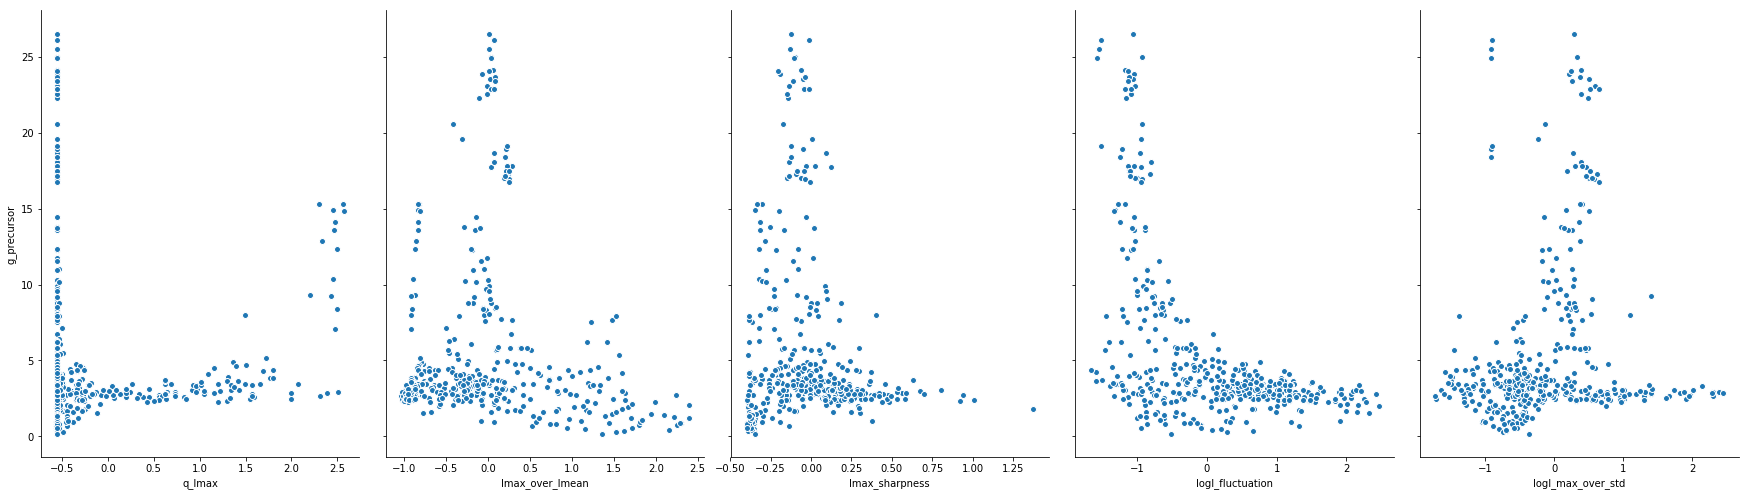

In [191]:
sns.pairplot(data_precursor, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='g_precursor', size=7, aspect=0.7)

In [192]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

for f in features:
    reg = linear_model.SGDRegressor()
    reg.fit(data_precursor[[f]], data_precursor['g_precursor'])
    pred = reg.predict(data_precursor[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_precursor['g_precursor'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_precursor['g_precursor'], pred))

Mean squared error: 28.50164
Variance score: 0.00044
Mean squared error: 28.46567
Variance score: 0.00170
Mean squared error: 28.24546
Variance score: 0.00943
Mean squared error: 20.76272
Variance score: 0.27185
Mean squared error: 27.85612
Variance score: 0.02308


We can try to use 1/'logI_fluctuation'

In [193]:
data_precursor['1/logI_fluctration'] = (1 / (data_precursor['logI_fluctuation'] +2)) 
data_precursor_test['1/logI_fluctration'] = (1 / (data_precursor_test['logI_fluctuation'] +2)) 

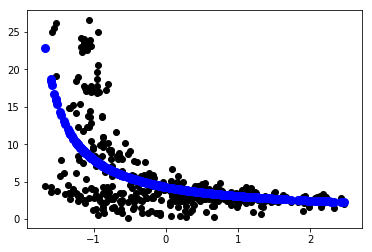

In [194]:
reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['1/logI_fluctration']], data_precursor['g_precursor'])
pred = reg.predict(data_precursor[['1/logI_fluctration']])
plt.scatter(data_precursor['logI_fluctuation'], data_precursor['g_precursor'],  color='black')
plt.scatter(data_precursor['logI_fluctuation'], pred, color='blue', linewidth=3)

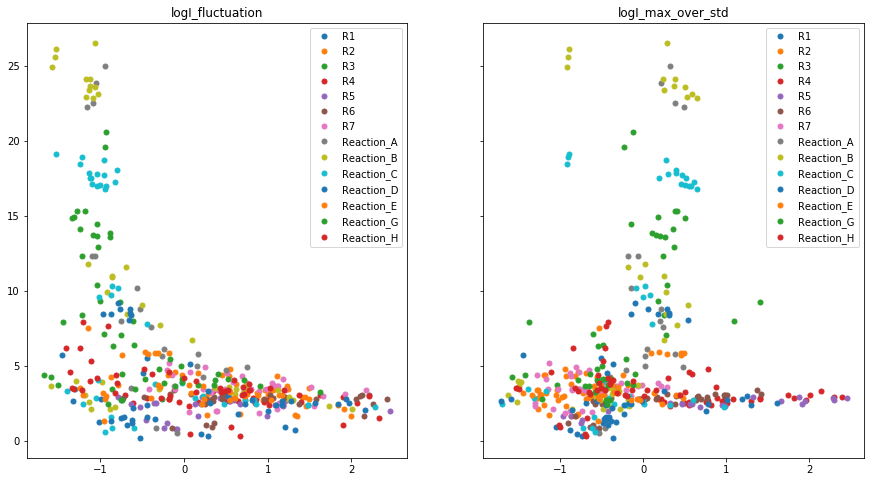

In [197]:
groups = data_precursor.groupby('experiment_id')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.logI_fluctuation, group.g_precursor, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('logI_fluctuation')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.g_precursor, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

plt.show()

In [200]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_precursor[['logI_fluctuation', 'g_precursor']])
grid.best_params_

{'bandwidth': 0.52206896551724147}

In [201]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.522).fit(data_precursor[['logI_fluctuation', 'g_precursor']])

log_pdf = kde.score_samples(data_precursor[['logI_fluctuation', 'g_precursor']])
sc = 1/np.exp(log_pdf)

data_precursor['weights_logI_fluctuation'] = sc

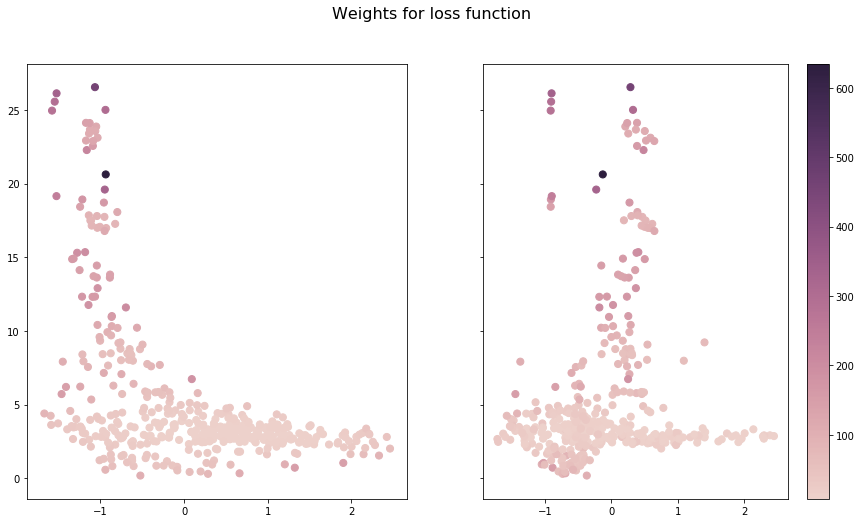

In [203]:
cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_precursor.logI_fluctuation, data_precursor.g_precursor, c=data_precursor['weights_logI_fluctuation'], s=50, cmap=cmap)
points2 = ax2.scatter(data_precursor.logI_max_over_std, data_precursor.g_precursor, c=data_precursor['weights_logI_fluctuation'], s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

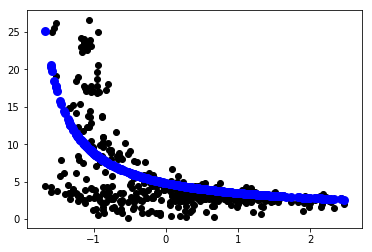

In [204]:
reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['1/logI_fluctration']], data_precursor['g_precursor'], sample_weight=data_precursor['weights_logI_fluctuation'])
pred = reg.predict(data_precursor[['1/logI_fluctration']])
plt.scatter(data_precursor['logI_fluctuation'], data_precursor['g_precursor'],  color='black')
plt.scatter(data_precursor['logI_fluctuation'], pred, color='blue', linewidth=3)

In [205]:
std_g_precursor = data_precursor['g_precursor'].std()

In [206]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['g_precursor']], groups=data_precursor['experiment_id'])

features = ['1/logI_fluctration']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['g_precursor'], sample_weight=data_precursor['weights_logI_fluctuation'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 1, 'l1_ratio': 0.95, 'loss': 'huber', 'penalty': 'none'}
Training score R2:  -6.727


In [209]:
features = ['1/logI_fluctration']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]

        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'huber', penalty= 'none', epsilon= 1)
        reg.fit(tr[features], tr['g_precursor'], sample_weight=tr['weights_logI_fluctuation'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -149.626011882
test score mean squared error normalized:  0.53331664652

Testing on:  R2
R2 score:  -0.138078349695
test score mean squared error normalized:  0.13080315239

Testing on:  R3
R2 score:  -0.731589685634
test score mean squared error normalized:  0.538992523055

Testing on:  R4
R2 score:  -8.69783672682
test score mean squared error normalized:  0.348392609259

Testing on:  R5
R2 score:  -10.385782181
test score mean squared error normalized:  0.378966577223

Testing on:  R6
R2 score:  -10.9138444883
test score mean squared error normalized:  0.329050074905

Testing on:  R7
R2 score:  -0.994325928875
test score mean squared error normalized:  0.174654053505

Testing on:  Reaction_A
R2 score:  0.329574597798
test score mean squared error normalized:  0.785120796904

Testing on:  Reaction_B
R2 score:  0.313522635635
test score mean squared error normalized:  0.999725982253

Testing on:  Reaction_C
R2 score:  0.248379206447
test score mean squared e

In [210]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['g_precursor']], groups=data_precursor['experiment_id'])

features = ['1/logI_fluctration', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['g_precursor'], sample_weight=data_precursor['weights_logI_fluctuation'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 0.001, 'l1_ratio': 0, 'loss': 'huber', 'penalty': 'l2'}
Training score R2:  -7.206


In [211]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]

        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'huber', penalty= 'l2', epsilon= 1)
        reg.fit(tr[features], tr['g_precursor'], sample_weight=tr['weights_logI_fluctuation'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -2.88059408355
test score mean squared error normalized:  0.0699541168376

Testing on:  R2
R2 score:  -11.6409585931
test score mean squared error normalized:  0.558640323745

Testing on:  R3
R2 score:  -7.07075056511
test score mean squared error normalized:  1.75694501848

Testing on:  R4
R2 score:  -8.81465359909
test score mean squared error normalized:  0.426900393407

Testing on:  R5
R2 score:  -7.92975718592
test score mean squared error normalized:  0.410954563969

Testing on:  R6
R2 score:  -13.2470243358
test score mean squared error normalized:  0.455444754561

Testing on:  R7
R2 score:  -16.3043075702
test score mean squared error normalized:  0.616830362964

Testing on:  Reaction_A
R2 score:  -1.38811836412
test score mean squared error normalized:  1.63759273988

Testing on:  Reaction_B
R2 score:  -1.15681117975
test score mean squared error normalized:  1.83740911964

Testing on:  Reaction_C
R2 score:  -1.55622973597
test score mean squared err

In [196]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['g_precursor']], groups=data_precursor['experiment_id'])

features = ['1/logI_fluctration', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['g_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 0.01, 'l1_ratio': 0.95, 'loss': 'huber', 'penalty': 'elasticnet'}
Training score R2:  -1.170


In [214]:
features = ['1/logI_fluctration', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]

        #reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
        reg = linear_model.SGDRegressor(max_iter=1000,alpha= 0.001, epsilon=0.01, l1_ratio=0.95, loss= 'huber', penalty= 'elasticnet')
        reg.fit(tr[features], tr['g_precursor'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -37.1668272005
test score mean squared error normalized:  0.282986815826

Testing on:  R2
R2 score:  -0.79245763183
test score mean squared error normalized:  0.18127160988

Testing on:  R3
R2 score:  -3.63868556519
test score mean squared error normalized:  1.27133880207

Testing on:  R4
R2 score:  0.0893048001891
test score mean squared error normalized:  0.1112190297

Testing on:  R5
R2 score:  0.171272728196
test score mean squared error normalized:  0.110433305175

Testing on:  R6
R2 score:  0.190188504965
test score mean squared error normalized:  0.100333059288

Testing on:  R7
R2 score:  -2.21000880541
test score mean squared error normalized:  0.239680537609

Testing on:  Reaction_A
R2 score:  -0.724924550704
test score mean squared error normalized:  1.2852265947

Testing on:  Reaction_B
R2 score:  -0.636206797411
test score mean squared error normalized:  1.42674094902

Testing on:  Reaction_C
R2 score:  -0.847215195907
test score mean squared erro

In [110]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['g_precursor']], groups=data_precursor['experiment_id'])

features = ['1/logI_fluctration']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['g_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 0.01, 'l1_ratio': 0, 'loss': 'huber', 'penalty': 'none'}
Training score R2:  -1.794


In [215]:
features = ['1/logI_fluctration']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(max_iter=1000, alpha= 0.0001, loss= 'huber', penalty= 'none', epsilon= 0.01)
        reg.fit(tr[features], tr['g_precursor'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -51.9970365176
test score mean squared error normalized:  0.329944931093

Testing on:  R2
R2 score:  -1.05897148597
test score mean squared error normalized:  0.1995914046

Testing on:  R3
R2 score:  -3.44213895023
test score mean squared error normalized:  1.24428116196

Testing on:  R4
R2 score:  -0.0410074312157
test score mean squared error normalized:  0.114687792939

Testing on:  R5
R2 score:  -0.248725045071
test score mean squared error normalized:  0.130913670132

Testing on:  R6
R2 score:  -0.248648922309
test score mean squared error normalized:  0.124647955901

Testing on:  R7
R2 score:  -2.14512098967
test score mean squared error normalized:  0.241142260143

Testing on:  Reaction_A
R2 score:  -0.69671097713
test score mean squared error normalized:  1.26408263229

Testing on:  Reaction_B
R2 score:  -0.591630651101
test score mean squared error normalized:  1.41916109174

Testing on:  Reaction_C
R2 score:  -0.782256344798
test score mean squared 

We got about the best result using o all 6 features.

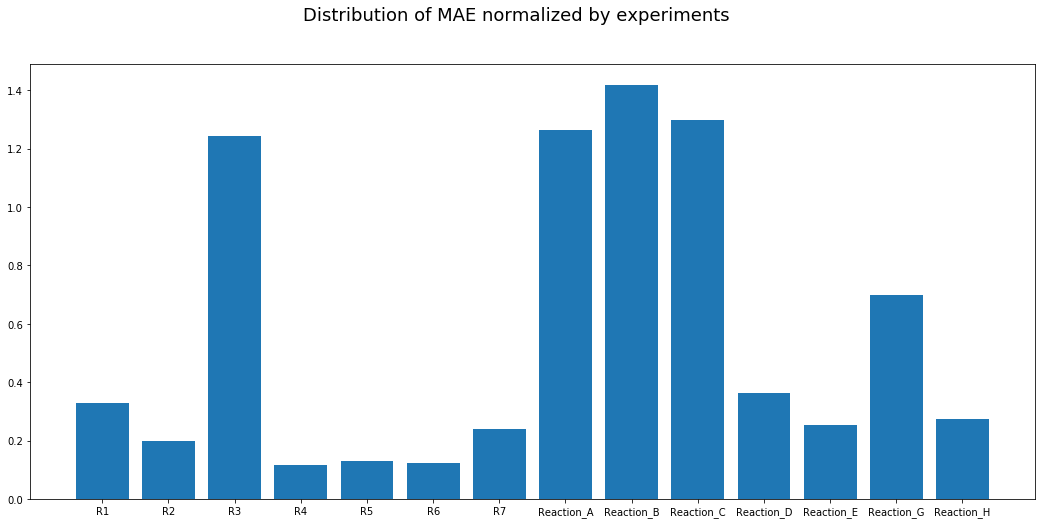

In [216]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

### rg_precursor

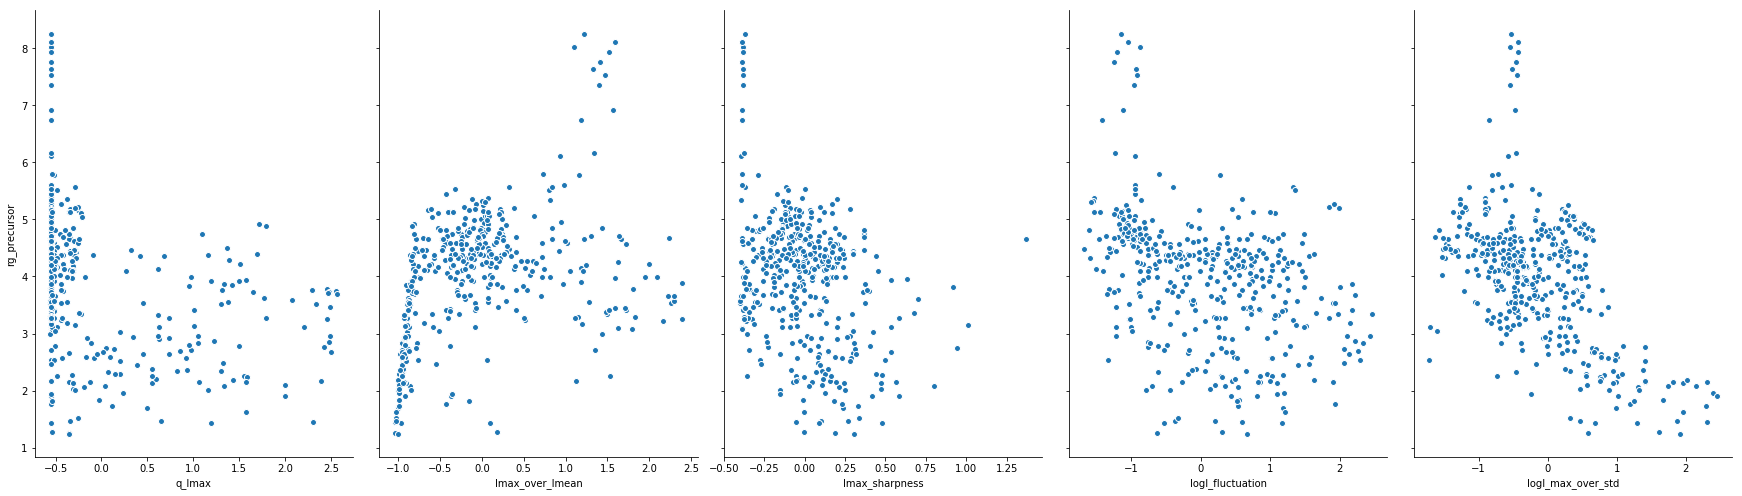

In [217]:
sns.pairplot(data_precursor, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='rg_precursor', size=7, aspect=0.7)

In [218]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

for f in features:
    reg = linear_model.SGDRegressor(max_iter=1000)
    reg.fit(data_precursor[[f]], data_precursor['rg_precursor'])
    pred = reg.predict(data_precursor[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_precursor['rg_precursor'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_precursor['rg_precursor'], pred))

Mean squared error: 1.08614
Variance score: 0.14752
Mean squared error: 1.04556
Variance score: 0.17937
Mean squared error: 1.11378
Variance score: 0.12583
Mean squared error: 1.07010
Variance score: 0.16012
Mean squared error: 0.88927
Variance score: 0.30204


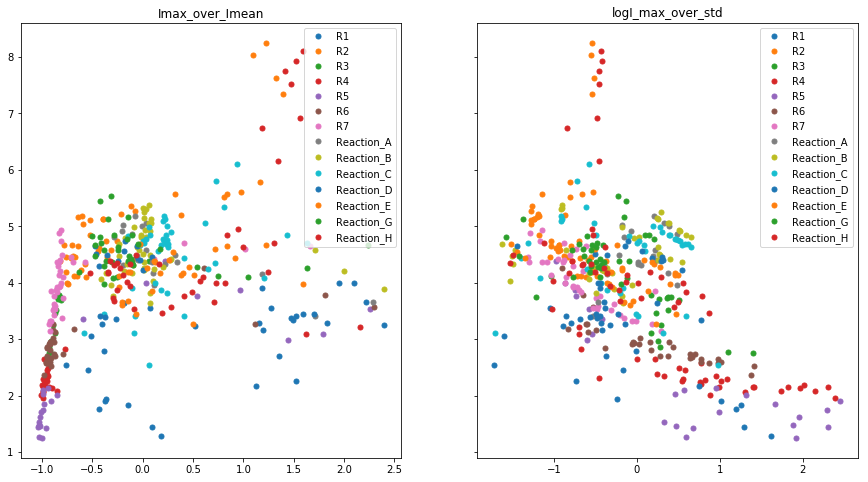

In [226]:
groups = data_precursor.groupby('experiment_id')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.Imax_over_Imean, group.rg_precursor, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Imax_over_Imean')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.rg_precursor, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

plt.show()

In [221]:
data_precursor['logI_max_over_std_squred'] = ( (data_precursor['logI_max_over_std'] - 2) ** 2) 
data_precursor_test['logI_max_over_std_squred'] = ( (data_precursor_test['logI_max_over_std'] - 2) ** 2)

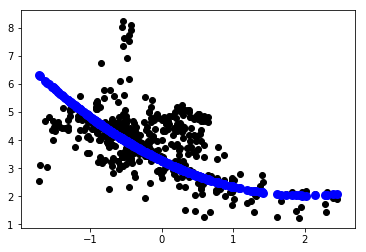

In [223]:
reg = linear_model.SGDRegressor(max_iter=10000, loss = 'huber', epsilon = 0.005)
reg.fit(data_precursor[['logI_max_over_std_squred']], data_precursor['rg_precursor'])
pred = reg.predict(data_precursor[['logI_max_over_std_squred']])
plt.scatter(data_precursor['logI_max_over_std'], data_precursor['rg_precursor'],  color='black')
plt.scatter(data_precursor['logI_max_over_std'], pred, color='blue', linewidth=3)

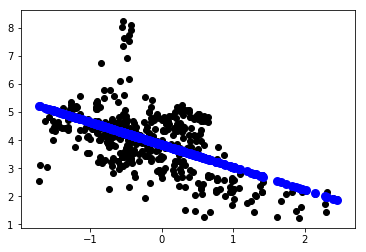

In [224]:
reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['logI_max_over_std']], data_precursor['rg_precursor'])
pred = reg.predict(data_precursor[['logI_max_over_std']])
plt.scatter(data_precursor['logI_max_over_std'], data_precursor['rg_precursor'],  color='black')
plt.scatter(data_precursor['logI_max_over_std'], pred, color='blue', linewidth=3)

In [227]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_precursor']], groups=data_precursor['experiment_id'])

features = ['logI_max_over_std_squred']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 0.01, 'l1_ratio': 0.15, 'loss': 'squared_loss', 'penalty': 'elasticnet'}
Training score R2:  -1.705


In [228]:
std_rg_precursor = data_precursor['rg_precursor'].std()

In [229]:
features = ['logI_max_over_std_squred']
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001, loss= 'squared_loss', penalty= 'elasticnet', l1_ratio = 0.15)
        reg.fit(tr[features], tr['rg_precursor'])
        test_r2 = reg.score(test[features], test['rg_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_precursor'])
        print('test score mean squared error normalized: ', test_score / std_rg_precursor)
        test_scores_by_ex.append(test_score/std_rg_precursor)
        stat_dic[experiments[i]] = test_score/std_rg_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -7.21567260104
test score mean squared error normalized:  1.20652538822

Testing on:  R2
R2 score:  -0.621133008624
test score mean squared error normalized:  0.457792155667

Testing on:  R3
R2 score:  -1.1692382882
test score mean squared error normalized:  0.530920025796

Testing on:  R4
R2 score:  0.150748978395
test score mean squared error normalized:  0.25643468942

Testing on:  R5
R2 score:  -2.85321999624
test score mean squared error normalized:  1.12990025555

Testing on:  R6
R2 score:  -0.749698857996
test score mean squared error normalized:  0.35391644915

Testing on:  R7
R2 score:  0.249495369519
test score mean squared error normalized:  0.296385654484

Testing on:  Reaction_A
R2 score:  -5.05597722272
test score mean squared error normalized:  1.2317190179

Testing on:  Reaction_B
R2 score:  -9.25398425263
test score mean squared error normalized:  1.02526721538

Testing on:  Reaction_C
R2 score:  -4.00649312014
test score mean squared error n

In [230]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_precursor']], groups=data_precursor['experiment_id'])

features = ['logI_max_over_std_squred','logI_max_over_std', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 1, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'none'}
Training score R2:  -0.843


In [231]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001,epsilon= 1, loss= 'huber', penalty= 'none')
        reg.fit(tr[features], tr['rg_precursor'])
        test_r2 = reg.score(test[features], test['rg_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_precursor'])
        print('test score mean squared error normalized: ', test_score / std_rg_precursor)
        test_scores_by_ex.append(test_score/std_rg_precursor)
        stat_dic[experiments[i]] = test_score/std_rg_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -7.74125032599
test score mean squared error normalized:  1.21831449597

Testing on:  R2
R2 score:  -3.31526952833
test score mean squared error normalized:  0.471839887877

Testing on:  R3
R2 score:  -4.36535791994
test score mean squared error normalized:  0.918130609378

Testing on:  R4
R2 score:  -5.44178034103
test score mean squared error normalized:  0.856489521936

Testing on:  R5
R2 score:  -28.9489531346
test score mean squared error normalized:  2.93004806201

Testing on:  R6
R2 score:  -0.852708819148
test score mean squared error normalized:  0.374574192107

Testing on:  R7
R2 score:  0.0907459409319
test score mean squared error normalized:  0.312184667719

Testing on:  Reaction_A
R2 score:  -2.34117388915
test score mean squared error normalized:  0.928159563324

Testing on:  Reaction_B
R2 score:  -7.26716239933
test score mean squared error normalized:  0.909055288804

Testing on:  Reaction_C
R2 score:  -2.42399314847
test score mean squared e

In this case, the single feature logI_max_over_std_squred works better than all 6 features.

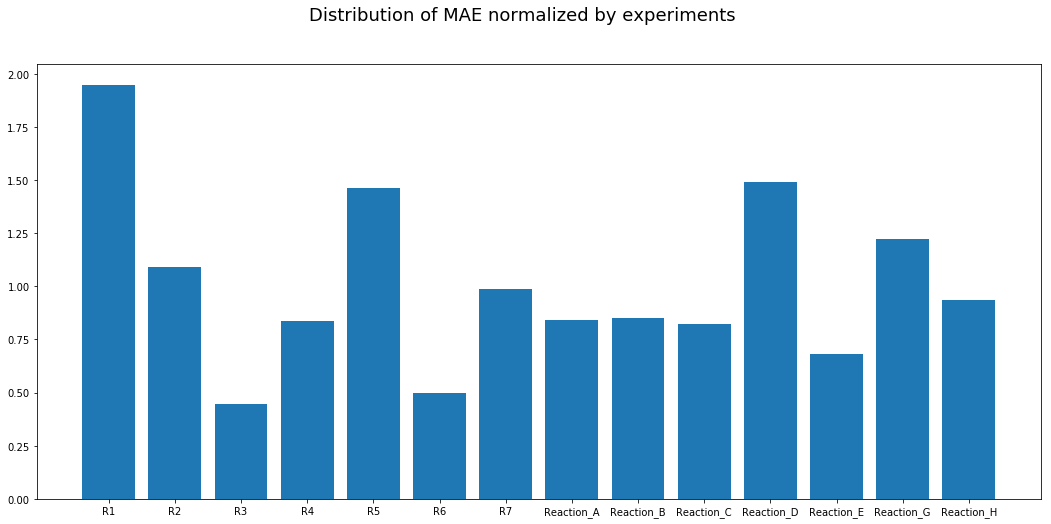

In [136]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()



|            | Average testing mean absolute error normalized | 
| ------------- | ------------- 
| ro_sphere  | 0.30
| sigma_sphere |  0.94 
|g_precursor | 0.56  | 
| rg_precursor | 0.81 |